# Take raw (Carriage return removed) csv, and assign each row a random number for shuffling, and put in sqlite database

In [3]:
# Put id, type, column in temp database
import sqlite3
import csv
import random
import sys
csv.field_size_limit(sys.maxsize)

random.seed(42)
n = 0

input_file = "cleaned_file.csv"

db_file = "temp_database.db"

conn = sqlite3.connect(db_file)
c = conn.cursor()
c.execute("CREATE TABLE data (id TEXT, type TEXT, content TEXT, title TEXT, rnd INT);")

with open(input_file, "r") as f_in:
    reader = csv.reader(f_in)
    header = next(reader)  # Read the header

    for row in reader:
        id_value = row[1].replace("\n", " ")
        type_value = row[3].replace("\n", " ")
        content_value = row[5].replace("\n", " ")
        title_value = row[9].replace("\n", " ")
        rnd_value = int(random.uniform(-9223372036854775808, 9223372036854775807)) # sqlite max/min int values

        c.execute("INSERT INTO data (id, type, content, title, rnd) VALUES (?, ?, ?, ?, ?)", (id_value, type_value, content_value, title_value, rnd_value))
        n += 1
        if n % 1000 == 0 and n:
            print("inserted", n, "rows\r", end = '')
conn.commit()
print()
print("finished")

inserted 8528000 rows
finished


# Shuffle and deduplicate database

In [3]:
import sqlite3
import csv
import random
import sys
csv.field_size_limit(sys.maxsize)
input_file = "cleaned_file.csv"
#output_file = "cleaned_file_shuffled.csv"
db_file = "temp_database.db"
# Create new shuffled table
conn = sqlite3.connect(db_file)
c = conn.cursor()

c.execute('''CREATE TABLE nodup AS
             SELECT id, type, content, title, rnd
             FROM data
             GROUP BY content
             ORDER BY rnd;''')

conn.commit()
conn.close()

# Delete the old database table to save space

In [4]:
conn = sqlite3.connect(db_file)
c = conn.cursor()

c.execute('''DROP TABLE IF EXISTS data''')

# Commit the changes and close the connection
conn.commit()
conn.close()

# load shuffled and deduped data back from database into csv

In [5]:
import csv
import sqlite3

# Set the batch size for reading the data from the SQLite table
batch_size = 400000
database_path = db_file
output_file = 'shuffled_dataset.csv'
# Connect to the database and create a cursor
conn = sqlite3.connect(database_path)
c = conn.cursor()

# Execute a SELECT statement to get the column names
c.execute("SELECT id, type, content, title FROM nodup LIMIT 0")
column_names = [description[0] for description in c.description]
print('column names:', column_names)

# Open the output file and write the header row
with open(output_file, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(column_names)

    # Execute a SELECT statement to read the data from the table in batches
    offset = 0
    while True:
        c.execute(f"SELECT id, type, content, title FROM nodup LIMIT {batch_size} OFFSET {offset}")
        rows = c.fetchall()

        # Break the loop if no more rows are returned
        if not rows:
            break

        # Write the rows to the output file
        writer.writerows(rows)

        # Increment the offset to read the next batch of rows
        offset += batch_size
# Close the database connection
conn.close()

column names: ['id', 'type', 'content', 'title']


# Delete entire database, to save space

In [6]:
import os
os.remove(database_path)

# Parquetise csv in chunks of 50000 rows (approx 100M)

In [7]:
## Parquetise sql filtered data
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq


csv_file_path = 'shuffled_dataset.csv'
parquet_file_prefix = 'cleaned_file.parquet/file_'
parquet_file_suffix = '.parquet'

column_dtypes = {
    "id": int,
    "type": object,
    "content": object,
    "title": object
}
#desired_columns = ['id', 'content', 'type']
chunk_size = 50000  # number of rows per chunk

# Iterate over the CSV file in chunks and write each chunk to a separate Parquet file
for i, chunk in enumerate(pd.read_csv(csv_file_path, chunksize=chunk_size, dtype=column_dtypes)):
    # Filter rows based on the "type" column
    #chunk = chunk.query('type == "fake" or type == "reliable"').copy()
        
    # Create the filename for the current chunk
    ident = str(i).zfill(4)
    parquet_file_path = parquet_file_prefix + ident + parquet_file_suffix

    # Write the current chunk to a Parquet file
    table = pa.Table.from_pandas(chunk)
    pq.write_table(table, parquet_file_path)
    print("\rchunk", ident)

chunk 0000
chunk 0001
chunk 0002
chunk 0003
chunk 0004
chunk 0005
chunk 0006
chunk 0007
chunk 0008
chunk 0009
chunk 0010
chunk 0011
chunk 0012
chunk 0013
chunk 0014
chunk 0015
chunk 0016
chunk 0017
chunk 0018
chunk 0019
chunk 0020
chunk 0021
chunk 0022
chunk 0023
chunk 0024
chunk 0025
chunk 0026
chunk 0027
chunk 0028
chunk 0029
chunk 0030
chunk 0031
chunk 0032
chunk 0033
chunk 0034
chunk 0035
chunk 0036
chunk 0037
chunk 0038
chunk 0039
chunk 0040
chunk 0041
chunk 0042
chunk 0043
chunk 0044
chunk 0045
chunk 0046
chunk 0047
chunk 0048
chunk 0049
chunk 0050
chunk 0051
chunk 0052
chunk 0053
chunk 0054
chunk 0055
chunk 0056
chunk 0057
chunk 0058
chunk 0059
chunk 0060
chunk 0061
chunk 0062
chunk 0063
chunk 0064
chunk 0065
chunk 0066
chunk 0067
chunk 0068
chunk 0069
chunk 0070
chunk 0071
chunk 0072
chunk 0073
chunk 0074
chunk 0075
chunk 0076
chunk 0077
chunk 0078
chunk 0079
chunk 0080
chunk 0081
chunk 0082
chunk 0083
chunk 0084
chunk 0085
chunk 0086
chunk 0087
chunk 0088
chunk 0089
chunk 0090

# Tokenise, lemmatise and vectorise, split and balance data into npz and npy files

In [2]:
import os
import glob
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from scipy.sparse import save_npz
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.decomposition import IncrementalPCA

# Custom tokenizer with lemmatization
def custom_tokenizer(text):
    # Expand contractions
    #expanded_text = contractions.fix(text)
    
    # Convert to lowercase
    lower_text = text.lower()
    
    # Tokenize with RegexpTokenizer
    tokenizer = RegexpTokenizer(r'\b[a-z]+\b')
    tokenized_words = tokenizer.tokenize(lower_text)

    # Load English stopwords
    stopwords_set = set(stopwords.words("english"))

    # Remove stopwords
    filtered_words = [word for word in tokenized_words if word not in stopwords_set]
    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    
    return lemmatized_words

label_mapping = {'reliable': 1, 'junksci': 0, 'political': 0, 'conspiracy': 0,
                'fake': 0, 'clickbait': 0, 'hate': 0, 'bias': 0, 'rumor': 0,
                'satire': 0, 'unreliable': 0}
allowed_types = list(label_mapping.keys())
""" Info!
type                n     mapping
reliable    :    1808242, 1
junksci     :      79435, 0
political   :     972306, 0
conspiracy  :     495436, 0
fake        :     770341, 0
empty       :     308029, exclude
unknown     :     231320, exclude
clickbait   :     176403, 0
hate        :      65265, 0
bias        :     771419, 0
rumor       :     376815, 0
satire      :      85526, 0
unreliable  :     104651, 0
"""


# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, max_features=2**13, use_idf=False)

# Directory containing your Parquet files
parquet_directory = 'shuffled_deduped.parquet/'
#parquet_directory = 'testrun.parquet/'

numpy_directory = 'numpyfiler/'
pca_dir = 'pca_dir/'

# First pass: Fit the TfidfVectorizer on the entire dataset
for parquet_file in sorted(glob.glob(os.path.join(parquet_directory, '*.parquet'))):
    print("first pass: Parsing", str(parquet_file))
    df = pd.read_parquet(parquet_file, engine='pyarrow')
    df = df[df['type'].isin(allowed_types)]
    tfidf_vectorizer.fit(df['content'])

# Update the TfidfVectorizer to use IDF
tfidf_vectorizer.use_idf = True

# Initialize counters for training and test set file indices
train_idx = 0
test_idx = 0
non_reliable = 3897597
reliable =     1808242
non_reliable_factor = reliable/non_reliable


# Second pass: Transform the content using the TfidfVectorizer and save it incrementally to separate files
for parquet_file in sorted(glob.glob(os.path.join(parquet_directory, '*.parquet'))):
    print("second pass: parsing", str(parquet_file))
    df = pd.read_parquet(parquet_file, engine='pyarrow')
    df = df[df['type'].isin(allowed_types)]
    #labels = np.array(df['type'])

    # Split the current chunk of data into training and testing sets
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

    # Separate the training chunk into fake and reliable classes
    train_reliable_df = train_df[train_df['type'] == 'reliable']
    train_non_reliable_df = train_df[train_df['type'] != 'reliable']

    # Multiply the number of reliable samples in the training chunk by the factor
    train_non_reliable_df_downsampled = train_non_reliable_df.sample(n=round(len(train_non_reliable_df) * non_reliable_factor), replace=False, random_state=42)

    # Concatenate the balanced training chunk
    train_balanced_df = pd.concat([train_reliable_df, train_non_reliable_df_downsampled], ignore_index=True).sample(frac=1, random_state=42)

    # Transform the content for the balanced training chunk and testing chunk
    X_train_balanced = tfidf_vectorizer.transform(train_balanced_df['content'])
    X_test_chunk = tfidf_vectorizer.transform(test_df['content'])

    # Create labels array for the balanced training chunk and testing chunk
    y_train_balanced = np.array([label_mapping[label] for label in train_balanced_df['type']])
    y_test_chunk = np.array([label_mapping[label] for label in test_df['type']])

    # Save the training data as .npz files
    save_npz(os.path.join(numpy_directory, f'X_train_{train_idx:04d}.npz'), X_train_balanced)
    np.save(os.path.join(numpy_directory, f'y_train_{train_idx:04d}.npy'), y_train_balanced)

    # Save the test data as .npz files
    save_npz(os.path.join(numpy_directory, f'X_test_{test_idx:04d}.npz'), X_test_chunk)
    np.save(os.path.join(numpy_directory, f'y_test_{test_idx:04d}.npy'), y_test_chunk)

    # Increment the counters
    train_idx += 1
    test_idx += 1
    




first pass: Parsing shuffled_deduped.parquet/file_0000.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0001.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0002.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0003.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0004.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0005.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0006.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0007.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0008.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0009.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0010.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0011.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0012.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0013.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0014.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0015.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0016.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0017.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0018.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0019.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0020.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0021.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0022.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0023.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0024.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0025.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0026.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0027.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0028.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0029.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0030.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0031.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0032.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0033.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0034.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0035.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0036.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0037.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0038.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0039.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0040.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0041.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0042.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0043.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0044.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0045.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0046.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0047.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0048.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0049.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0050.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0051.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0052.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0053.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0054.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0055.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0056.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0057.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0058.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0059.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0060.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0061.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0062.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0063.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0064.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0065.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0066.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0067.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0068.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0069.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0070.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0071.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0072.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0073.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0074.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0075.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0076.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0077.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0078.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0079.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0080.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0081.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0082.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0083.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0084.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0085.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0086.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0087.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0088.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0089.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0090.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0091.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0092.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0093.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0094.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0095.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0096.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0097.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0098.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0099.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0100.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0101.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0102.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0103.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0104.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0105.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0106.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0107.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0108.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0109.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0110.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0111.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0112.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0113.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0114.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0115.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0116.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0117.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0118.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0119.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0120.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0121.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0122.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0123.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


first pass: Parsing shuffled_deduped.parquet/file_0124.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


second pass: parsing shuffled_deduped.parquet/file_0000.parquet
second pass: parsing shuffled_deduped.parquet/file_0001.parquet
second pass: parsing shuffled_deduped.parquet/file_0002.parquet
second pass: parsing shuffled_deduped.parquet/file_0003.parquet
second pass: parsing shuffled_deduped.parquet/file_0004.parquet
second pass: parsing shuffled_deduped.parquet/file_0005.parquet
second pass: parsing shuffled_deduped.parquet/file_0006.parquet
second pass: parsing shuffled_deduped.parquet/file_0007.parquet
second pass: parsing shuffled_deduped.parquet/file_0008.parquet
second pass: parsing shuffled_deduped.parquet/file_0009.parquet
second pass: parsing shuffled_deduped.parquet/file_0010.parquet
second pass: parsing shuffled_deduped.parquet/file_0011.parquet
second pass: parsing shuffled_deduped.parquet/file_0012.parquet
second pass: parsing shuffled_deduped.parquet/file_0013.parquet
second pass: parsing shuffled_deduped.parquet/file_0014.parquet
second pass: parsing shuffled_deduped.pa

In [1]:
# CHATGPT
import os
import glob
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from scipy.sparse import save_npz
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.decomposition import IncrementalPCA

# Custom tokenizer with lemmatization
def custom_tokenizer(text):
    # Expand contractions
    #expanded_text = contractions.fix(text)
    
    # Convert to lowercase
    lower_text = text.lower()
    
    # Tokenize with RegexpTokenizer
    tokenizer = RegexpTokenizer(r'\b[a-z]+\b')
    tokenized_words = tokenizer.tokenize(lower_text)

    # Load English stopwords
    stopwords_set = set(stopwords.words("english"))

    # Remove stopwords
    filtered_words = [word for word in tokenized_words if word not in stopwords_set]
    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    
    return lemmatized_words

label_mapping = {'reliable': 1, 'junksci': 0, 'political': 0, 'conspiracy': 0,
                'fake': 0, 'clickbait': 0, 'hate': 0, 'bias': 0, 'rumor': 0,
                'satire': 0, 'unreliable': 0}
allowed_types = list(label_mapping.keys())

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(sublinear_tf = True, tokenizer=custom_tokenizer, max_features=2**12, use_idf=False)

# Directory containing your Parquet files
parquet_directory = 'shuffled_deduped.parquet/'
#parquet_directory = 'testrun.parquet/'

numpy_directory = 'numpyfiler/'
pca_dir = 'pca_dir/'

# Initialize counters for training and test set file indices
train_idx = 0
test_idx = 0
non_reliable = 3897597
reliable =     1808242
non_reliable_factor = reliable/non_reliable

# Iterate through the Parquet files, splitting the data into train and test sets, and fitting the TfidfVectorizer
for parquet_file in sorted(glob.glob(os.path.join(parquet_directory, '*.parquet'))):
    print("parsing", str(parquet_file))
    df = pd.read_parquet(parquet_file, engine='pyarrow')
    df = df[df['type'].isin(allowed_types)]

    # Split the current chunk of data into training and testing sets
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

    # Fit the TfidfVectorizer on the training set
    tfidf_vectorizer.fit(train_df['content'])

# Update the TfidfVectorizer to use IDF
tfidf_vectorizer.use_idf = True

# Iterate through the Parquet files again, transforming the content using the TfidfVectorizer, and saving the vectorized versions
for parquet_file in sorted(glob.glob(os.path.join(parquet_directory, '*.parquet'))):
    print("second pass: parsing", str(parquet_file))
    df = pd.read_parquet(parquet_file, engine='pyarrow')
    df = df[df['type'].isin(allowed_types)]

    # Split the current chunk of data into training and testing sets
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

    # Transform the content for the training and testing sets
    X_train_chunk = tfidf_vectorizer.transform(train_df['content'])
    X_test_chunk = tfidf_vectorizer.transform(test_df['content'])

    # Create labels array for the training and testing sets
    y_train_chunk = np.array([label_mapping[label] for label in train_df['type']])
    y_test_chunk = np.array([label_mapping[label] for label in test_df['type']])

    # Save the training data as .npz files
    save_npz(os.path.join(numpy_directory, f'X_train_{train_idx:04d}.npz'), X_train_chunk)
    np.save(os.path.join(numpy_directory, f'y_train_{train_idx:04d}.npy'), y_train_chunk)

    # Save the test data as .npz files
    save_npz(os.path.join(numpy_directory, f'X_test_{test_idx:04d}.npz'), X_test_chunk)
    np.save(os.path.join(numpy_directory, f'y_test_{test_idx:04d}.npy'), y_test_chunk)

    # Increment the counters
    train_idx += 1
    test_idx += 1


parsing shuffled_deduped.parquet/file_0000.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0001.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0002.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0003.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0004.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0005.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0006.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0007.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0008.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0009.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0010.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0011.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0012.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0013.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0014.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0015.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0016.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0017.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0018.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0019.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0020.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0021.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0022.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0023.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0024.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0025.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0026.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0027.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0028.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0029.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0030.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0031.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0032.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0033.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0034.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0035.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0036.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0037.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0038.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0039.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0040.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0041.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0042.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0043.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0044.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0045.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0046.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0047.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0048.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0049.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0050.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0051.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0052.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0053.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0054.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0055.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0056.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0057.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0058.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0059.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0060.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0061.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0062.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0063.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0064.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0065.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0066.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0067.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0068.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0069.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0070.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0071.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0072.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0073.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0074.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0075.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0076.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0077.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0078.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0079.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0080.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0081.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0082.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0083.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0084.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0085.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0086.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0087.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0088.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0089.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0090.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0091.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0092.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0093.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0094.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0095.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0096.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0097.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0098.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0099.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0100.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0101.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0102.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0103.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0104.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0105.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0106.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0107.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0108.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0109.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0110.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0111.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0112.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0113.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0114.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0115.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0116.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0117.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0118.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0119.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0120.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0121.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0122.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0123.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


parsing shuffled_deduped.parquet/file_0124.parquet


/home/jakupl/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


second pass: parsing shuffled_deduped.parquet/file_0000.parquet
second pass: parsing shuffled_deduped.parquet/file_0001.parquet
second pass: parsing shuffled_deduped.parquet/file_0002.parquet
second pass: parsing shuffled_deduped.parquet/file_0003.parquet
second pass: parsing shuffled_deduped.parquet/file_0004.parquet
second pass: parsing shuffled_deduped.parquet/file_0005.parquet
second pass: parsing shuffled_deduped.parquet/file_0006.parquet
second pass: parsing shuffled_deduped.parquet/file_0007.parquet
second pass: parsing shuffled_deduped.parquet/file_0008.parquet
second pass: parsing shuffled_deduped.parquet/file_0009.parquet
second pass: parsing shuffled_deduped.parquet/file_0010.parquet
second pass: parsing shuffled_deduped.parquet/file_0011.parquet
second pass: parsing shuffled_deduped.parquet/file_0012.parquet
second pass: parsing shuffled_deduped.parquet/file_0013.parquet
second pass: parsing shuffled_deduped.parquet/file_0014.parquet
second pass: parsing shuffled_deduped.pa

In [2]:
import pickle

# Function to generate a unique filename
def get_unique_filename(filename_prefix):
    counter = 1
    while os.path.exists(f'{filename_prefix}{counter}'):
        counter += 1
    return f'{filename_prefix}{counter}'

filename_prefix = 'tfidf_vectorizer'
filename_prefix = get_unique_filename(filename_prefix)

with open(filename_prefix+'.pkl', 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)


# Train a neural network on train data

In [3]:
import os
import numpy as np
from scipy.sparse import load_npz
import glob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
numpy_dir = 'numpyfiler/'

# Load the training data
train_files = sorted(glob.glob(numpy_dir+'X_train_*.npz'))
train_label_files = sorted(glob.glob(numpy_dir+'y_train_*.npy'))

# Determine the input dimension from the first training file
input_dim = load_npz(train_files[0]).shape[1]

# Create a neural network model
model = Sequential()
model.add(Dense(1024, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

# Train the model incrementally using the saved training set files
batch_size = 1536
epochs = 1

for x_file, y_file in zip(train_files, train_label_files):
    print("training on", x_file, y_file)
    X_train_chunk = load_npz(x_file)
    y_train_chunk = np.load(y_file, allow_pickle=True)

    # Train the model in smaller batches
    num_samples = X_train_chunk.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, num_samples)

            X_batch = X_train_chunk[start_idx:end_idx].todense()
            y_batch = y_train_chunk[start_idx:end_idx]

            loss, acc = model.train_on_batch(X_batch, y_batch)
            print(f" - Batch {batch_idx + 1}/{num_batches}: loss={loss:.4f}, accuracy={acc:.4f}")
            


# Function to generate a unique filename
def get_unique_filename(filename_prefix):
    counter = 1
    while os.path.exists(f'{filename_prefix}{counter}'):
        counter += 1
    return f'{filename_prefix}{counter}'

# Save the model
unique_filename = get_unique_filename('my_saved_model')
model.save(unique_filename)


2023-03-23 12:51:44.545233: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-23 12:51:44.916986: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-23 12:51:44.917008: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-23 12:51:46.185297: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

training on numpyfiler/X_train_0000.npz numpyfiler/y_train_0000.npy
Epoch 1/1
 - Batch 1/24: loss=0.6924, accuracy=0.5749
 - Batch 2/24: loss=0.6863, accuracy=0.6764
 - Batch 3/24: loss=0.6777, accuracy=0.6842
 - Batch 4/24: loss=0.6655, accuracy=0.6882
 - Batch 5/24: loss=0.6491, accuracy=0.6908
 - Batch 6/24: loss=0.6327, accuracy=0.6862
 - Batch 7/24: loss=0.6102, accuracy=0.6908
 - Batch 8/24: loss=0.5950, accuracy=0.6914
 - Batch 9/24: loss=0.5884, accuracy=0.6921
 - Batch 10/24: loss=0.6096, accuracy=0.6621
 - Batch 11/24: loss=0.5991, accuracy=0.6745
 - Batch 12/24: loss=0.5470, accuracy=0.6986
 - Batch 13/24: loss=0.5606, accuracy=0.6673
 - Batch 14/24: loss=0.5312, accuracy=0.6940
 - Batch 15/24: loss=0.5318, accuracy=0.6790
 - Batch 16/24: loss=0.5057, accuracy=0.6882
 - Batch 17/24: loss=0.5142, accuracy=0.6647
 - Batch 18/24: loss=0.4824, accuracy=0.6908
 - Batch 19/24: loss=0.4689, accuracy=0.6914
 - Batch 20/24: loss=0.4595, accuracy=0.6875
 - Batch 21/24: loss=0.4346, ac

 - Batch 3/24: loss=0.1403, accuracy=0.9473
 - Batch 4/24: loss=0.1424, accuracy=0.9473
 - Batch 5/24: loss=0.1464, accuracy=0.9440
 - Batch 6/24: loss=0.1502, accuracy=0.9427
 - Batch 7/24: loss=0.1598, accuracy=0.9447
 - Batch 8/24: loss=0.1759, accuracy=0.9323
 - Batch 9/24: loss=0.1733, accuracy=0.9329
 - Batch 10/24: loss=0.1710, accuracy=0.9421
 - Batch 11/24: loss=0.1657, accuracy=0.9368
 - Batch 12/24: loss=0.1904, accuracy=0.9329
 - Batch 13/24: loss=0.1485, accuracy=0.9460
 - Batch 14/24: loss=0.1675, accuracy=0.9375
 - Batch 15/24: loss=0.1604, accuracy=0.9368
 - Batch 16/24: loss=0.1513, accuracy=0.9408
 - Batch 17/24: loss=0.1798, accuracy=0.9316
 - Batch 18/24: loss=0.1446, accuracy=0.9414
 - Batch 19/24: loss=0.1466, accuracy=0.9466
 - Batch 20/24: loss=0.1628, accuracy=0.9440
 - Batch 21/24: loss=0.1717, accuracy=0.9316
 - Batch 22/24: loss=0.1548, accuracy=0.9362
 - Batch 23/24: loss=0.1784, accuracy=0.9310
 - Batch 24/24: loss=0.1788, accuracy=0.9417
training on numpy

 - Batch 7/24: loss=0.1351, accuracy=0.9466
 - Batch 8/24: loss=0.1410, accuracy=0.9499
 - Batch 9/24: loss=0.1310, accuracy=0.9518
 - Batch 10/24: loss=0.1471, accuracy=0.9505
 - Batch 11/24: loss=0.1397, accuracy=0.9466
 - Batch 12/24: loss=0.1216, accuracy=0.9622
 - Batch 13/24: loss=0.1258, accuracy=0.9551
 - Batch 14/24: loss=0.1308, accuracy=0.9479
 - Batch 15/24: loss=0.1400, accuracy=0.9466
 - Batch 16/24: loss=0.1495, accuracy=0.9473
 - Batch 17/24: loss=0.1453, accuracy=0.9492
 - Batch 18/24: loss=0.1475, accuracy=0.9414
 - Batch 19/24: loss=0.1419, accuracy=0.9466
 - Batch 20/24: loss=0.1415, accuracy=0.9518
 - Batch 21/24: loss=0.1255, accuracy=0.9564
 - Batch 22/24: loss=0.1530, accuracy=0.9414
 - Batch 23/24: loss=0.1227, accuracy=0.9505
 - Batch 24/24: loss=0.1342, accuracy=0.9508
training on numpyfiler/X_train_0015.npz numpyfiler/y_train_0015.npy
Epoch 1/1
 - Batch 1/24: loss=0.1325, accuracy=0.9564
 - Batch 2/24: loss=0.1439, accuracy=0.9499
 - Batch 3/24: loss=0.1226,

 - Batch 11/24: loss=0.1118, accuracy=0.9590
 - Batch 12/24: loss=0.1257, accuracy=0.9531
 - Batch 13/24: loss=0.1002, accuracy=0.9674
 - Batch 14/24: loss=0.1100, accuracy=0.9609
 - Batch 15/24: loss=0.1053, accuracy=0.9648
 - Batch 16/24: loss=0.1079, accuracy=0.9577
 - Batch 17/24: loss=0.1044, accuracy=0.9616
 - Batch 18/24: loss=0.1460, accuracy=0.9538
 - Batch 19/24: loss=0.1332, accuracy=0.9518
 - Batch 20/24: loss=0.1320, accuracy=0.9551
 - Batch 21/24: loss=0.1254, accuracy=0.9473
 - Batch 22/24: loss=0.1199, accuracy=0.9518
 - Batch 23/24: loss=0.1151, accuracy=0.9590
 - Batch 24/24: loss=0.1175, accuracy=0.9597
training on numpyfiler/X_train_0022.npz numpyfiler/y_train_0022.npy
Epoch 1/1
 - Batch 1/24: loss=0.1271, accuracy=0.9486
 - Batch 2/24: loss=0.1043, accuracy=0.9590
 - Batch 3/24: loss=0.1106, accuracy=0.9622
 - Batch 4/24: loss=0.1157, accuracy=0.9596
 - Batch 5/24: loss=0.1266, accuracy=0.9557
 - Batch 6/24: loss=0.1122, accuracy=0.9635
 - Batch 7/24: loss=0.1078, 

 - Batch 15/24: loss=0.1219, accuracy=0.9577
 - Batch 16/24: loss=0.1028, accuracy=0.9668
 - Batch 17/24: loss=0.1136, accuracy=0.9616
 - Batch 18/24: loss=0.1023, accuracy=0.9616
 - Batch 19/24: loss=0.0920, accuracy=0.9655
 - Batch 20/24: loss=0.1273, accuracy=0.9525
 - Batch 21/24: loss=0.1157, accuracy=0.9551
 - Batch 22/24: loss=0.1408, accuracy=0.9447
 - Batch 23/24: loss=0.1069, accuracy=0.9622
 - Batch 24/24: loss=0.0902, accuracy=0.9640
training on numpyfiler/X_train_0029.npz numpyfiler/y_train_0029.npy
Epoch 1/1
 - Batch 1/24: loss=0.1167, accuracy=0.9544
 - Batch 2/24: loss=0.1024, accuracy=0.9616
 - Batch 3/24: loss=0.1199, accuracy=0.9551
 - Batch 4/24: loss=0.1070, accuracy=0.9583
 - Batch 5/24: loss=0.1122, accuracy=0.9577
 - Batch 6/24: loss=0.1153, accuracy=0.9616
 - Batch 7/24: loss=0.1014, accuracy=0.9622
 - Batch 8/24: loss=0.0853, accuracy=0.9714
 - Batch 9/24: loss=0.1132, accuracy=0.9544
 - Batch 10/24: loss=0.1145, accuracy=0.9557
 - Batch 11/24: loss=0.1076, ac

 - Batch 19/24: loss=0.1139, accuracy=0.9531
 - Batch 20/24: loss=0.1045, accuracy=0.9668
 - Batch 21/24: loss=0.1054, accuracy=0.9655
 - Batch 22/24: loss=0.1107, accuracy=0.9603
 - Batch 23/24: loss=0.1076, accuracy=0.9609
 - Batch 24/24: loss=0.1168, accuracy=0.9549
training on numpyfiler/X_train_0036.npz numpyfiler/y_train_0036.npy
Epoch 1/1
 - Batch 1/24: loss=0.0939, accuracy=0.9642
 - Batch 2/24: loss=0.1097, accuracy=0.9635
 - Batch 3/24: loss=0.0927, accuracy=0.9674
 - Batch 4/24: loss=0.0997, accuracy=0.9616
 - Batch 5/24: loss=0.0926, accuracy=0.9707
 - Batch 6/24: loss=0.0953, accuracy=0.9622
 - Batch 7/24: loss=0.1047, accuracy=0.9603
 - Batch 8/24: loss=0.1076, accuracy=0.9583
 - Batch 9/24: loss=0.1035, accuracy=0.9603
 - Batch 10/24: loss=0.1216, accuracy=0.9525
 - Batch 11/24: loss=0.0850, accuracy=0.9707
 - Batch 12/24: loss=0.0963, accuracy=0.9648
 - Batch 13/24: loss=0.0905, accuracy=0.9714
 - Batch 14/24: loss=0.0935, accuracy=0.9648
 - Batch 15/24: loss=0.1049, ac

 - Batch 23/24: loss=0.0813, accuracy=0.9727
 - Batch 24/24: loss=0.0902, accuracy=0.9689
training on numpyfiler/X_train_0043.npz numpyfiler/y_train_0043.npy
Epoch 1/1
 - Batch 1/24: loss=0.0928, accuracy=0.9642
 - Batch 2/24: loss=0.1147, accuracy=0.9668
 - Batch 3/24: loss=0.1102, accuracy=0.9642
 - Batch 4/24: loss=0.1400, accuracy=0.9466
 - Batch 5/24: loss=0.1109, accuracy=0.9583
 - Batch 6/24: loss=0.1082, accuracy=0.9629
 - Batch 7/24: loss=0.0855, accuracy=0.9746
 - Batch 8/24: loss=0.0978, accuracy=0.9577
 - Batch 9/24: loss=0.0884, accuracy=0.9681
 - Batch 10/24: loss=0.1005, accuracy=0.9603
 - Batch 11/24: loss=0.1154, accuracy=0.9564
 - Batch 12/24: loss=0.1085, accuracy=0.9583
 - Batch 13/24: loss=0.0804, accuracy=0.9714
 - Batch 14/24: loss=0.0897, accuracy=0.9688
 - Batch 15/24: loss=0.1092, accuracy=0.9590
 - Batch 16/24: loss=0.0991, accuracy=0.9596
 - Batch 17/24: loss=0.0931, accuracy=0.9635
 - Batch 18/24: loss=0.0788, accuracy=0.9733
 - Batch 19/24: loss=0.1046, ac

Epoch 1/1
 - Batch 1/24: loss=0.1148, accuracy=0.9577
 - Batch 2/24: loss=0.0852, accuracy=0.9681
 - Batch 3/24: loss=0.1012, accuracy=0.9661
 - Batch 4/24: loss=0.0946, accuracy=0.9655
 - Batch 5/24: loss=0.1123, accuracy=0.9622
 - Batch 6/24: loss=0.1077, accuracy=0.9681
 - Batch 7/24: loss=0.0846, accuracy=0.9701
 - Batch 8/24: loss=0.0915, accuracy=0.9681
 - Batch 9/24: loss=0.0926, accuracy=0.9655
 - Batch 10/24: loss=0.0965, accuracy=0.9655
 - Batch 11/24: loss=0.0853, accuracy=0.9681
 - Batch 12/24: loss=0.0946, accuracy=0.9622
 - Batch 13/24: loss=0.0968, accuracy=0.9668
 - Batch 14/24: loss=0.0867, accuracy=0.9707
 - Batch 15/24: loss=0.1036, accuracy=0.9564
 - Batch 16/24: loss=0.1039, accuracy=0.9603
 - Batch 17/24: loss=0.0858, accuracy=0.9694
 - Batch 18/24: loss=0.1073, accuracy=0.9603
 - Batch 19/24: loss=0.0962, accuracy=0.9590
 - Batch 20/24: loss=0.0858, accuracy=0.9688
 - Batch 21/24: loss=0.0985, accuracy=0.9642
 - Batch 22/24: loss=0.0869, accuracy=0.9668
 - Batch 

 - Batch 5/24: loss=0.0856, accuracy=0.9661
 - Batch 6/24: loss=0.0975, accuracy=0.9603
 - Batch 7/24: loss=0.1009, accuracy=0.9596
 - Batch 8/24: loss=0.0983, accuracy=0.9635
 - Batch 9/24: loss=0.0979, accuracy=0.9616
 - Batch 10/24: loss=0.0831, accuracy=0.9707
 - Batch 11/24: loss=0.1007, accuracy=0.9603
 - Batch 12/24: loss=0.0968, accuracy=0.9629
 - Batch 13/24: loss=0.0937, accuracy=0.9629
 - Batch 14/24: loss=0.0986, accuracy=0.9674
 - Batch 15/24: loss=0.0778, accuracy=0.9714
 - Batch 16/24: loss=0.0980, accuracy=0.9694
 - Batch 17/24: loss=0.0962, accuracy=0.9661
 - Batch 18/24: loss=0.0922, accuracy=0.9616
 - Batch 19/24: loss=0.0902, accuracy=0.9655
 - Batch 20/24: loss=0.0964, accuracy=0.9635
 - Batch 21/24: loss=0.1057, accuracy=0.9590
 - Batch 22/24: loss=0.0985, accuracy=0.9635
 - Batch 23/24: loss=0.0871, accuracy=0.9707
 - Batch 24/24: loss=0.0797, accuracy=0.9653
training on numpyfiler/X_train_0058.npz numpyfiler/y_train_0058.npy
Epoch 1/1
 - Batch 1/24: loss=0.0845,

 - Batch 9/24: loss=0.0964, accuracy=0.9642
 - Batch 10/24: loss=0.0892, accuracy=0.9681
 - Batch 11/24: loss=0.0785, accuracy=0.9701
 - Batch 12/24: loss=0.0849, accuracy=0.9642
 - Batch 13/24: loss=0.0977, accuracy=0.9616
 - Batch 14/24: loss=0.0865, accuracy=0.9668
 - Batch 15/24: loss=0.0928, accuracy=0.9674
 - Batch 16/24: loss=0.0841, accuracy=0.9681
 - Batch 17/24: loss=0.0776, accuracy=0.9746
 - Batch 18/24: loss=0.0695, accuracy=0.9714
 - Batch 19/24: loss=0.0917, accuracy=0.9642
 - Batch 20/24: loss=0.0862, accuracy=0.9701
 - Batch 21/24: loss=0.0729, accuracy=0.9733
 - Batch 22/24: loss=0.0847, accuracy=0.9668
 - Batch 23/24: loss=0.0877, accuracy=0.9688
 - Batch 24/24: loss=0.0848, accuracy=0.9728
training on numpyfiler/X_train_0065.npz numpyfiler/y_train_0065.npy
Epoch 1/1
 - Batch 1/24: loss=0.0871, accuracy=0.9635
 - Batch 2/24: loss=0.0846, accuracy=0.9661
 - Batch 3/24: loss=0.0757, accuracy=0.9688
 - Batch 4/24: loss=0.0860, accuracy=0.9668
 - Batch 5/24: loss=0.0959,

 - Batch 13/24: loss=0.1026, accuracy=0.9616
 - Batch 14/24: loss=0.1005, accuracy=0.9635
 - Batch 15/24: loss=0.0728, accuracy=0.9759
 - Batch 16/24: loss=0.1000, accuracy=0.9577
 - Batch 17/24: loss=0.0791, accuracy=0.9727
 - Batch 18/24: loss=0.0773, accuracy=0.9720
 - Batch 19/24: loss=0.0786, accuracy=0.9642
 - Batch 20/24: loss=0.1063, accuracy=0.9622
 - Batch 21/24: loss=0.0967, accuracy=0.9622
 - Batch 22/24: loss=0.0818, accuracy=0.9753
 - Batch 23/24: loss=0.1029, accuracy=0.9590
 - Batch 24/24: loss=0.0801, accuracy=0.9672
training on numpyfiler/X_train_0072.npz numpyfiler/y_train_0072.npy
Epoch 1/1
 - Batch 1/24: loss=0.0953, accuracy=0.9635
 - Batch 2/24: loss=0.0765, accuracy=0.9733
 - Batch 3/24: loss=0.0914, accuracy=0.9694
 - Batch 4/24: loss=0.0893, accuracy=0.9668
 - Batch 5/24: loss=0.0810, accuracy=0.9668
 - Batch 6/24: loss=0.1003, accuracy=0.9629
 - Batch 7/24: loss=0.0904, accuracy=0.9701
 - Batch 8/24: loss=0.0924, accuracy=0.9635
 - Batch 9/24: loss=0.0815, ac

 - Batch 17/24: loss=0.0705, accuracy=0.9727
 - Batch 18/24: loss=0.0824, accuracy=0.9707
 - Batch 19/24: loss=0.0781, accuracy=0.9746
 - Batch 20/24: loss=0.0737, accuracy=0.9759
 - Batch 21/24: loss=0.0760, accuracy=0.9668
 - Batch 22/24: loss=0.0755, accuracy=0.9753
 - Batch 23/24: loss=0.0815, accuracy=0.9714
 - Batch 24/24: loss=0.0900, accuracy=0.9634
training on numpyfiler/X_train_0079.npz numpyfiler/y_train_0079.npy
Epoch 1/1
 - Batch 1/24: loss=0.0911, accuracy=0.9668
 - Batch 2/24: loss=0.0834, accuracy=0.9674
 - Batch 3/24: loss=0.0897, accuracy=0.9681
 - Batch 4/24: loss=0.0674, accuracy=0.9727
 - Batch 5/24: loss=0.0786, accuracy=0.9746
 - Batch 6/24: loss=0.0789, accuracy=0.9727
 - Batch 7/24: loss=0.1018, accuracy=0.9629
 - Batch 8/24: loss=0.0906, accuracy=0.9642
 - Batch 9/24: loss=0.0883, accuracy=0.9694
 - Batch 10/24: loss=0.0962, accuracy=0.9616
 - Batch 11/24: loss=0.0756, accuracy=0.9746
 - Batch 12/24: loss=0.0982, accuracy=0.9635
 - Batch 13/24: loss=0.0682, ac

 - Batch 21/24: loss=0.0866, accuracy=0.9661
 - Batch 22/24: loss=0.0759, accuracy=0.9727
 - Batch 23/24: loss=0.0711, accuracy=0.9720
 - Batch 24/24: loss=0.0968, accuracy=0.9672
training on numpyfiler/X_train_0086.npz numpyfiler/y_train_0086.npy
Epoch 1/1
 - Batch 1/24: loss=0.0888, accuracy=0.9674
 - Batch 2/24: loss=0.0790, accuracy=0.9733
 - Batch 3/24: loss=0.0980, accuracy=0.9642
 - Batch 4/24: loss=0.0770, accuracy=0.9707
 - Batch 5/24: loss=0.0835, accuracy=0.9642
 - Batch 6/24: loss=0.0712, accuracy=0.9759
 - Batch 7/24: loss=0.0914, accuracy=0.9661
 - Batch 8/24: loss=0.0969, accuracy=0.9661
 - Batch 9/24: loss=0.0869, accuracy=0.9707
 - Batch 10/24: loss=0.0816, accuracy=0.9648
 - Batch 11/24: loss=0.0881, accuracy=0.9642
 - Batch 12/24: loss=0.0790, accuracy=0.9688
 - Batch 13/24: loss=0.1094, accuracy=0.9629
 - Batch 14/24: loss=0.0915, accuracy=0.9694
 - Batch 15/24: loss=0.0947, accuracy=0.9655
 - Batch 16/24: loss=0.0810, accuracy=0.9681
 - Batch 17/24: loss=0.0973, ac

Epoch 1/1
 - Batch 1/24: loss=0.0833, accuracy=0.9720
 - Batch 2/24: loss=0.0862, accuracy=0.9655
 - Batch 3/24: loss=0.0881, accuracy=0.9740
 - Batch 4/24: loss=0.0735, accuracy=0.9707
 - Batch 5/24: loss=0.0813, accuracy=0.9766
 - Batch 6/24: loss=0.0869, accuracy=0.9674
 - Batch 7/24: loss=0.0846, accuracy=0.9688
 - Batch 8/24: loss=0.0879, accuracy=0.9681
 - Batch 9/24: loss=0.0831, accuracy=0.9681
 - Batch 10/24: loss=0.0773, accuracy=0.9779
 - Batch 11/24: loss=0.0749, accuracy=0.9720
 - Batch 12/24: loss=0.0811, accuracy=0.9694
 - Batch 13/24: loss=0.0793, accuracy=0.9707
 - Batch 14/24: loss=0.0920, accuracy=0.9648
 - Batch 15/24: loss=0.0883, accuracy=0.9720
 - Batch 16/24: loss=0.0738, accuracy=0.9772
 - Batch 17/24: loss=0.0734, accuracy=0.9740
 - Batch 18/24: loss=0.0853, accuracy=0.9694
 - Batch 19/24: loss=0.0801, accuracy=0.9727
 - Batch 20/24: loss=0.0882, accuracy=0.9668
 - Batch 21/24: loss=0.0747, accuracy=0.9701
 - Batch 22/24: loss=0.0804, accuracy=0.9733
 - Batch 

 - Batch 5/24: loss=0.0854, accuracy=0.9668
 - Batch 6/24: loss=0.0750, accuracy=0.9727
 - Batch 7/24: loss=0.0784, accuracy=0.9681
 - Batch 8/24: loss=0.0822, accuracy=0.9688
 - Batch 9/24: loss=0.0810, accuracy=0.9746
 - Batch 10/24: loss=0.0889, accuracy=0.9681
 - Batch 11/24: loss=0.0633, accuracy=0.9785
 - Batch 12/24: loss=0.0804, accuracy=0.9727
 - Batch 13/24: loss=0.0991, accuracy=0.9583
 - Batch 14/24: loss=0.0811, accuracy=0.9661
 - Batch 15/24: loss=0.0788, accuracy=0.9701
 - Batch 16/24: loss=0.0774, accuracy=0.9681
 - Batch 17/24: loss=0.0892, accuracy=0.9681
 - Batch 18/24: loss=0.0787, accuracy=0.9714
 - Batch 19/24: loss=0.0621, accuracy=0.9759
 - Batch 20/24: loss=0.0724, accuracy=0.9707
 - Batch 21/24: loss=0.0860, accuracy=0.9668
 - Batch 22/24: loss=0.0785, accuracy=0.9688
 - Batch 23/24: loss=0.0847, accuracy=0.9674
 - Batch 24/24: loss=0.0771, accuracy=0.9729
training on numpyfiler/X_train_0101.npz numpyfiler/y_train_0101.npy
Epoch 1/1
 - Batch 1/24: loss=0.0674,

 - Batch 9/24: loss=0.0893, accuracy=0.9661
 - Batch 10/24: loss=0.0773, accuracy=0.9753
 - Batch 11/24: loss=0.0846, accuracy=0.9661
 - Batch 12/24: loss=0.0732, accuracy=0.9753
 - Batch 13/24: loss=0.0943, accuracy=0.9648
 - Batch 14/24: loss=0.0857, accuracy=0.9688
 - Batch 15/24: loss=0.0901, accuracy=0.9655
 - Batch 16/24: loss=0.0843, accuracy=0.9661
 - Batch 17/24: loss=0.0922, accuracy=0.9655
 - Batch 18/24: loss=0.0827, accuracy=0.9733
 - Batch 19/24: loss=0.0821, accuracy=0.9688
 - Batch 20/24: loss=0.0866, accuracy=0.9714
 - Batch 21/24: loss=0.0828, accuracy=0.9714
 - Batch 22/24: loss=0.0707, accuracy=0.9733
 - Batch 23/24: loss=0.0908, accuracy=0.9681
 - Batch 24/24: loss=0.0981, accuracy=0.9640
training on numpyfiler/X_train_0108.npz numpyfiler/y_train_0108.npy
Epoch 1/1
 - Batch 1/24: loss=0.0888, accuracy=0.9674
 - Batch 2/24: loss=0.0765, accuracy=0.9720
 - Batch 3/24: loss=0.0785, accuracy=0.9740
 - Batch 4/24: loss=0.0618, accuracy=0.9772
 - Batch 5/24: loss=0.0790,

 - Batch 13/24: loss=0.0737, accuracy=0.9727
 - Batch 14/24: loss=0.0756, accuracy=0.9733
 - Batch 15/24: loss=0.0835, accuracy=0.9655
 - Batch 16/24: loss=0.0897, accuracy=0.9668
 - Batch 17/24: loss=0.0792, accuracy=0.9668
 - Batch 18/24: loss=0.0729, accuracy=0.9766
 - Batch 19/24: loss=0.0720, accuracy=0.9746
 - Batch 20/24: loss=0.0822, accuracy=0.9740
 - Batch 21/24: loss=0.0879, accuracy=0.9668
 - Batch 22/24: loss=0.0759, accuracy=0.9779
 - Batch 23/24: loss=0.0672, accuracy=0.9753
 - Batch 24/24: loss=0.0847, accuracy=0.9668
training on numpyfiler/X_train_0115.npz numpyfiler/y_train_0115.npy
Epoch 1/1
 - Batch 1/24: loss=0.0615, accuracy=0.9798
 - Batch 2/24: loss=0.0792, accuracy=0.9720
 - Batch 3/24: loss=0.0685, accuracy=0.9759
 - Batch 4/24: loss=0.0716, accuracy=0.9759
 - Batch 5/24: loss=0.1061, accuracy=0.9635
 - Batch 6/24: loss=0.0859, accuracy=0.9655
 - Batch 7/24: loss=0.0810, accuracy=0.9694
 - Batch 8/24: loss=0.1018, accuracy=0.9648
 - Batch 9/24: loss=0.0960, ac

 - Batch 17/24: loss=0.0708, accuracy=0.9733
 - Batch 18/24: loss=0.0728, accuracy=0.9740
 - Batch 19/24: loss=0.0911, accuracy=0.9642
 - Batch 20/24: loss=0.0811, accuracy=0.9701
 - Batch 21/24: loss=0.0710, accuracy=0.9766
 - Batch 22/24: loss=0.0883, accuracy=0.9733
 - Batch 23/24: loss=0.0984, accuracy=0.9635
 - Batch 24/24: loss=0.0820, accuracy=0.9679
training on numpyfiler/X_train_0122.npz numpyfiler/y_train_0122.npy
Epoch 1/1
 - Batch 1/24: loss=0.0873, accuracy=0.9629
 - Batch 2/24: loss=0.0644, accuracy=0.9779
 - Batch 3/24: loss=0.0788, accuracy=0.9714
 - Batch 4/24: loss=0.0747, accuracy=0.9648
 - Batch 5/24: loss=0.0817, accuracy=0.9688
 - Batch 6/24: loss=0.0791, accuracy=0.9701
 - Batch 7/24: loss=0.0762, accuracy=0.9720
 - Batch 8/24: loss=0.0843, accuracy=0.9707
 - Batch 9/24: loss=0.0864, accuracy=0.9701
 - Batch 10/24: loss=0.0820, accuracy=0.9681
 - Batch 11/24: loss=0.0695, accuracy=0.9727
 - Batch 12/24: loss=0.0694, accuracy=0.9772
 - Batch 13/24: loss=0.0899, ac

INFO:tensorflow:Assets written to: my_saved_model10/assets


INFO:tensorflow:Assets written to: my_saved_model10/assets


# Make predictions on test data 

In [4]:
import numpy as np
from scipy.sparse import load_npz
import glob
from sklearn.metrics import accuracy_score
batch_size = 128
# Load the test set files
numpy_dir = 'numpyfiler/'
test_files = sorted(glob.glob(numpy_dir+'X_test_*.npz'))
test_label_files = sorted(glob.glob(numpy_dir+'y_test_*.npy'))

y_pred = []
y_true = []

# Make predictions on the test data
for x_file, y_file in zip(test_files, test_label_files):
    print("predicting on", x_file, y_file)
    X_test_chunk = load_npz(x_file)
    y_test_chunk = np.load(y_file, allow_pickle=True)

    # Process the test data in smaller batches
    num_samples = X_test_chunk.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size

    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, num_samples)

        X_batch = X_test_chunk[start_idx:end_idx].todense()
        y_batch = y_test_chunk[start_idx:end_idx]

        # Get the predictions for this batch
        y_pred_chunk = model.predict(X_batch)
        
        # Since the output activation is sigmoid, we need to threshold the predictions
        y_pred_chunk = (y_pred_chunk > 0.5).astype(int).flatten()
        
        y_pred.extend(y_pred_chunk)
        y_true.extend(y_batch)

# Calculate the accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

predicting on numpyfiler/X_test_0000.npz numpyfiler/y_test_0000.npy
3/3 [==============================] - 0s 7ms/step
predicting on numpyfiler/X_test_0001.npz numpyfiler/y_test_0001.npy
2/2 [==============================] - 0s 6ms/step
predicting on numpyfiler/X_test_0002.npz numpyfiler/y_test_0002.npy
4/4 [==============================] - 0s 19ms/step


2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0003.npz numpyfiler/y_test_0003.npy
2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0004.npz numpyfiler/y_test_0004.npy
4/4 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 24ms/step
predicting on numpyfiler/X_test_0005.npz numpyfiler/y_test_0005.npy
2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0006.npz numpyfiler/y_test_0006.npy
4/4 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0007.npz numpyfiler/y_test_0007.npy
2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0008.npz numpyfiler/y_test_0008.npy
4/4 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0009.npz numpyfiler/y_test_0009.npy
1/1 [==============================] - 0s 20ms/step
predicting on numpyfiler/X_test_0010.npz numpyfiler/y_test_0010.npy
4/4 [==============================] - 0s 8ms/step


3/3 [==============================] - 0s 6ms/step
predicting on numpyfiler/X_test_0011.npz numpyfiler/y_test_0011.npy
2/2 [==============================] - 0s 9ms/step
predicting on numpyfiler/X_test_0012.npz numpyfiler/y_test_0012.npy
4/4 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0013.npz numpyfiler/y_test_0013.npy
2/2 [==============================] - 0s 8ms/step
predicting on numpyfiler/X_test_0014.npz numpyfiler/y_test_0014.npy
2/2 [==============================] - 0s 12ms/step
predicting on numpyfiler/X_test_0015.npz numpyfiler/y_test_0015.npy
4/4 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0016.npz numpyfiler/y_test_0016.npy
2/2 [==============================] - 0s 7ms/step
predicting on numpyfiler/X_test_0017.npz numpyfiler/y_test_0017.npy
4/4 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step
predicting on numpyfiler/X_test_0018.npz numpyfiler/y_test_0018.npy
2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0019.npz numpyfiler/y_test_0019.npy
4/4 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step
predicting on numpyfiler/X_test_0020.npz numpyfiler/y_test_0020.npy
2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0021.npz numpyfiler/y_test_0021.npy
4/4 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0022.npz numpyfiler/y_test_0022.npy
2/2 [==============================] - 0s 7ms/step
predicting on numpyfiler/X_test_0023.npz numpyfiler/y_test_0023.npy
4/4 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step
predicting on numpyfiler/X_test_0024.npz numpyfiler/y_test_0024.npy
2/2 [==============================] - 0s 7ms/step
predicting on numpyfiler/X_test_0025.npz numpyfiler/y_test_0025.npy
4/4 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 10ms/step
predicting on numpyfiler/X_test_0026.npz numpyfiler/y_test_0026.npy
2/2 [==============================] - 0s 10ms/step
predicting on numpyfiler/X_test_0027.npz numpyfiler/y_test_0027.npy
3/3 [==============================] - 0s 7ms/step
predicting on numpyfiler/X_test_0028.npz numpyfiler/y_test_0028.npy
4/4 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step
predicting on numpyfiler/X_test_0029.npz numpyfiler/y_test_0029.npy
2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0030.npz numpyfiler/y_test_0030.npy
4/4 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step
predicting on numpyfiler/X_test_0031.npz numpyfiler/y_test_0031.npy
2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0032.npz numpyfiler/y_test_0032.npy
4/4 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step
predicting on numpyfiler/X_test_0033.npz numpyfiler/y_test_0033.npy
2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0034.npz numpyfiler/y_test_0034.npy
4/4 [==============================] - 0s 11ms/step


3/3 [==============================] - 0s 7ms/step
predicting on numpyfiler/X_test_0035.npz numpyfiler/y_test_0035.npy
2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0036.npz numpyfiler/y_test_0036.npy
4/4 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0037.npz numpyfiler/y_test_0037.npy
2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0038.npz numpyfiler/y_test_0038.npy
4/4 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 15ms/step
predicting on numpyfiler/X_test_0039.npz numpyfiler/y_test_0039.npy
1/1 [==============================] - 0s 26ms/step
predicting on numpyfiler/X_test_0040.npz numpyfiler/y_test_0040.npy
4/4 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step
predicting on numpyfiler/X_test_0041.npz numpyfiler/y_test_0041.npy
2/2 [==============================] - 0s 6ms/step
predicting on numpyfiler/X_test_0042.npz numpyfiler/y_test_0042.npy
2/2 [==============================] - 0s 11ms/step
predicting on numpyfiler/X_test_0043.npz numpyfiler/y_test_0043.npy
4/4 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0044.npz numpyfiler/y_test_0044.npy
2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0045.npz numpyfiler/y_test_0045.npy
4/4 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0046.npz numpyfiler/y_test_0046.npy
2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0047.npz numpyfiler/y_test_0047.npy
4/4 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 27ms/step
predicting on numpyfiler/X_test_0048.npz numpyfiler/y_test_0048.npy
2/2 [==============================] - 0s 10ms/step
predicting on numpyfiler/X_test_0049.npz numpyfiler/y_test_0049.npy
4/4 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step
predicting on numpyfiler/X_test_0050.npz numpyfiler/y_test_0050.npy
2/2 [==============================] - 0s 10ms/step
predicting on numpyfiler/X_test_0051.npz numpyfiler/y_test_0051.npy
4/4 [==============================] - 0s 9ms/step


3/3 [==============================] - 0s 7ms/step
predicting on numpyfiler/X_test_0052.npz numpyfiler/y_test_0052.npy
2/2 [==============================] - 0s 12ms/step
predicting on numpyfiler/X_test_0053.npz numpyfiler/y_test_0053.npy
4/4 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0054.npz numpyfiler/y_test_0054.npy
3/3 [==============================] - 0s 7ms/step
predicting on numpyfiler/X_test_0055.npz numpyfiler/y_test_0055.npy
4/4 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 10ms/step
predicting on numpyfiler/X_test_0056.npz numpyfiler/y_test_0056.npy
2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0057.npz numpyfiler/y_test_0057.npy
2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0058.npz numpyfiler/y_test_0058.npy
4/4 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step
predicting on numpyfiler/X_test_0059.npz numpyfiler/y_test_0059.npy
1/1 [==============================] - 0s 29ms/step
predicting on numpyfiler/X_test_0060.npz numpyfiler/y_test_0060.npy
4/4 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0061.npz numpyfiler/y_test_0061.npy
2/2 [==============================] - 0s 19ms/step
predicting on numpyfiler/X_test_0062.npz numpyfiler/y_test_0062.npy
4/4 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0063.npz numpyfiler/y_test_0063.npy
1/1 [==============================] - 0s 24ms/step
predicting on numpyfiler/X_test_0064.npz numpyfiler/y_test_0064.npy
4/4 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 12ms/step
predicting on numpyfiler/X_test_0065.npz numpyfiler/y_test_0065.npy
2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0066.npz numpyfiler/y_test_0066.npy
4/4 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step
predicting on numpyfiler/X_test_0067.npz numpyfiler/y_test_0067.npy
2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0068.npz numpyfiler/y_test_0068.npy
4/4 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step
predicting on numpyfiler/X_test_0069.npz numpyfiler/y_test_0069.npy
2/2 [==============================] - 0s 4ms/step
predicting on numpyfiler/X_test_0070.npz numpyfiler/y_test_0070.npy
2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0071.npz numpyfiler/y_test_0071.npy
4/4 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0072.npz numpyfiler/y_test_0072.npy
2/2 [==============================] - 0s 8ms/step
predicting on numpyfiler/X_test_0073.npz numpyfiler/y_test_0073.npy
4/4 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0074.npz numpyfiler/y_test_0074.npy
2/2 [==============================] - 0s 6ms/step
predicting on numpyfiler/X_test_0075.npz numpyfiler/y_test_0075.npy
4/4 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step
predicting on numpyfiler/X_test_0076.npz numpyfiler/y_test_0076.npy
2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0077.npz numpyfiler/y_test_0077.npy
4/4 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0078.npz numpyfiler/y_test_0078.npy
1/1 [==============================] - 0s 24ms/step
predicting on numpyfiler/X_test_0079.npz numpyfiler/y_test_0079.npy
4/4 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step
predicting on numpyfiler/X_test_0080.npz numpyfiler/y_test_0080.npy
1/1 [==============================] - 0s 28ms/step
predicting on numpyfiler/X_test_0081.npz numpyfiler/y_test_0081.npy
4/4 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0082.npz numpyfiler/y_test_0082.npy
3/3 [==============================] - 0s 7ms/step
predicting on numpyfiler/X_test_0083.npz numpyfiler/y_test_0083.npy
4/4 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step
predicting on numpyfiler/X_test_0084.npz numpyfiler/y_test_0084.npy
3/3 [==============================] - 0s 10ms/step
predicting on numpyfiler/X_test_0085.npz numpyfiler/y_test_0085.npy
2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0086.npz numpyfiler/y_test_0086.npy
4/4 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0087.npz numpyfiler/y_test_0087.npy
2/2 [==============================] - 0s 6ms/step
predicting on numpyfiler/X_test_0088.npz numpyfiler/y_test_0088.npy
4/4 [==============================] - 0s 11ms/step


3/3 [==============================] - 0s 7ms/step
predicting on numpyfiler/X_test_0089.npz numpyfiler/y_test_0089.npy
2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0090.npz numpyfiler/y_test_0090.npy
4/4 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step
predicting on numpyfiler/X_test_0091.npz numpyfiler/y_test_0091.npy
2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0092.npz numpyfiler/y_test_0092.npy
4/4 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0093.npz numpyfiler/y_test_0093.npy
2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0094.npz numpyfiler/y_test_0094.npy
4/4 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step
predicting on numpyfiler/X_test_0095.npz numpyfiler/y_test_0095.npy
2/2 [==============================] - 0s 6ms/step
predicting on numpyfiler/X_test_0096.npz numpyfiler/y_test_0096.npy
4/4 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0097.npz numpyfiler/y_test_0097.npy
2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0098.npz numpyfiler/y_test_0098.npy
2/2 [==============================] - 0s 10ms/step
predicting on numpyfiler/X_test_0099.npz numpyfiler/y_test_0099.npy


2/2 [==============================] - 0s 7ms/step
predicting on numpyfiler/X_test_0100.npz numpyfiler/y_test_0100.npy
2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0101.npz numpyfiler/y_test_0101.npy
4/4 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step
predicting on numpyfiler/X_test_0102.npz numpyfiler/y_test_0102.npy
1/1 [==============================] - 0s 30ms/step
predicting on numpyfiler/X_test_0103.npz numpyfiler/y_test_0103.npy
4/4 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0104.npz numpyfiler/y_test_0104.npy
1/1 [==============================] - 0s 24ms/step
predicting on numpyfiler/X_test_0105.npz numpyfiler/y_test_0105.npy
4/4 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0106.npz numpyfiler/y_test_0106.npy
2/2 [==============================] - 0s 10ms/step
predicting on numpyfiler/X_test_0107.npz numpyfiler/y_test_0107.npy
4/4 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 6ms/step
predicting on numpyfiler/X_test_0108.npz numpyfiler/y_test_0108.npy
2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0109.npz numpyfiler/y_test_0109.npy
4/4 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0110.npz numpyfiler/y_test_0110.npy
2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0111.npz numpyfiler/y_test_0111.npy
4/4 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0112.npz numpyfiler/y_test_0112.npy
2/2 [==============================] - 0s 6ms/step
predicting on numpyfiler/X_test_0113.npz numpyfiler/y_test_0113.npy
2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0114.npz numpyfiler/y_test_0114.npy
4/4 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step
predicting on numpyfiler/X_test_0115.npz numpyfiler/y_test_0115.npy
2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0116.npz numpyfiler/y_test_0116.npy
4/4 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 13ms/step
predicting on numpyfiler/X_test_0117.npz numpyfiler/y_test_0117.npy
2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0118.npz numpyfiler/y_test_0118.npy
4/4 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0119.npz numpyfiler/y_test_0119.npy
2/2 [==============================] - 0s 5ms/step
predicting on numpyfiler/X_test_0120.npz numpyfiler/y_test_0120.npy
4/4 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 10ms/step
predicting on numpyfiler/X_test_0121.npz numpyfiler/y_test_0121.npy
2/2 [==============================] - 0s 10ms/step
predicting on numpyfiler/X_test_0122.npz numpyfiler/y_test_0122.npy
4/4 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step
predicting on numpyfiler/X_test_0123.npz numpyfiler/y_test_0123.npy
2/2 [==============================] - 0s 10ms/step
predicting on numpyfiler/X_test_0124.npz numpyfiler/y_test_0124.npy
4/4 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step
Accuracy: 0.9731217233502071


# Print confusion matrix

Text(0, 0.5, 'True label')

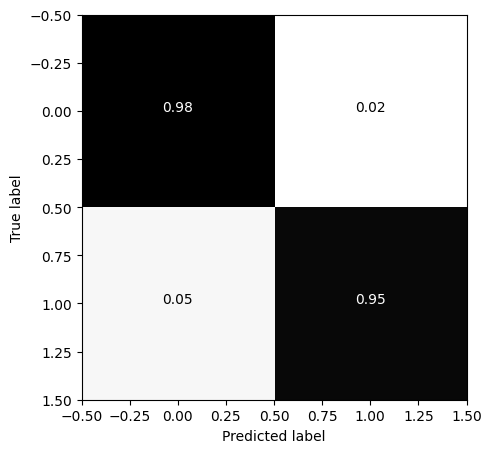

In [5]:
from sklearn import metrics
import matplotlib.pyplot as plt
# Make confusion matrix
confusion_matrix = metrics.confusion_matrix(y_true, y_pred, normalize="true")
# Plot confusion matrix
plt.figure(figsize=(5, 5))
plt.imshow(confusion_matrix, interpolation="nearest", cmap=plt.cm.gray_r)
for i in range(2):
    for j in range(2):
        plt.text(j, i, format(confusion_matrix[i, j], '.2f'), horizontalalignment="center", color="white" if confusion_matrix[i, j] > 0.5 else "black")
plt.xlabel("Predicted label")
plt.ylabel("True label")

# Just for fun, test model on current news

In [21]:
some_article="""LONDON, March 22 (Reuters) - British consumer price inflation unexpectedly rose to 10.4% in February, pushed up by drinks prices in pubs and restaurants, official data showed on Wednesday, a day before the Bank of England announces its latest decision on interest rates

Economists polled by Reuters had forecast that the annual CPI rate would drop to 9.9% in February from January's 10.1% and move further away from October's 41-year high of 11.1%.

The BoE is due to announce on Thursday whether it has raised interest rates for an 11th meeting in a row.
article-prompt-devices
Register for free to Reuters and know the full story

Investors are split on whether it will pause its run of increases in borrowing costs because of the recent upheaval in the global banking sector.

"Given the market movements of late, this puts the Bank of England in an incredibly difficult position as it may not be enough for the Bank of England to press pause on the rate hikes," Richard Carter, head of fixed interest research at Quilter Cheviot, said.

Sterling rose against the dollar and the euro after the data was published.

The ONS said that an end to January drinks promotions in pubs and restaurants was the biggest factor pushing up inflation last month, but shortages of salad items also played a role.

"Food and non-alcoholic drink prices rose to their highest rate in over 45 years with particular increases for some salad and vegetable items as high energy costs and bad weather across parts of Europe led to shortages and rationing," ONS chief economist Grant Fitzner said.

Core CPI - which excludes energy, food, alcohol and tobacco and is watched closed by the BoE - rose to 6.2% from 5.8% in January, versus a forecast decline to 5.7%.

The annual inflation rate in the services sector, which most policymakers consider is a good measure of underlying price pressures in the economy, rose to 6.6% after standing at 6.0% in January.

Finance minister Jeremy Hunt said the data showed the expected decline in inflation could not be taken for granted.

"Falling inflation isn't inevitable, so we need to stick to our plan to halve it this year," Hunt said in a statement.

On Tuesday, he told lawmakers that inflation above 10% was "dangerously high."""

In [22]:
some_article = [some_article]
X_some_article = tfidf_vectorizer.transform(some_article)
model.predict(X_some_article)

1/1 [==============================] - 0s 13ms/step


array([[0.59687835]], dtype=float32)